In [1]:
import os
from io import BytesIO
from gradient_generator import generate_gradient
import ETL
import pandas as pd
from fpdf import FPDF
import matplotlib.pyplot as plt
import html2image
from PyPDF2 import PdfMerger


In [2]:
def hex_to_rgb(hex: str):
    hex = hex.lstrip("#")
    hlen = len(hex)
    return tuple(int(hex[i : i + hlen // 3], 16) for i in range(0, hlen, hlen // 3))


def contrast(colors: list[str]):
    mean = (0, 0, 0)
    for color in colors:
        r, g, b = hex_to_rgb(color)
        mean = (mean[0] + r, mean[1] + g, mean[2] + b)
    mean = (mean[0] / len(colors), mean[1] / len(colors), mean[2] / len(colors))
    r, g, b = mean
    return "000000" if (r * 0.299 + g * 0.587 + b * 0.114) > 186 else "FFFFFF"


def get_logo_url(team_info: dict):
    if team_info["Key"] == "ATL":
        return "https://i0.wp.com/sportytell.com/wp-content/uploads/2020/11/NBA-atlanta-hawks-Logo.png?resize=300%2C300&ssl=1"
    elif team_info["Key"] == "TOR":
        return "https://i1.wp.com/sportytell.com/wp-content/uploads/2020/11/NBA-toronto-raptors-Logo.png?resize=300%2C300&ssl=1"
    elif team_info["Key"] == "UTA":
        return "https://i1.wp.com/sportytell.com/wp-content/uploads/2020/11/NBA-utah-jazz-Logo.png?resize=300%2C300&ssl=1"
    elif team_info["Key"] == "HOU":
        return "https://i0.wp.com/sportytell.com/wp-content/uploads/2020/11/NBA-houston-rockets-Logo.png?resize=300%2C300&ssl=1"
    elif team_info["Key"] == "NO":
        return "https://i2.wp.com/sportytell.com/wp-content/uploads/2020/11/NBA-new-orleans-pelicans-Logo.png?resize=300%2C300&ssl=1"
    return team_info["WikipediaLogoUrl"]


contrast(["0064B1", "00285E"])


'FFFFFF'

In [3]:
import time

ini = time.time()

## Config and Main Info

In [4]:
config = ETL.get_config()
api_key = config["api_key"]
season = config["season"]
input_team = config["team"]

team_info = ETL.get_main_team_info(api_key, input_team)
print("team_info")


team_info


## Front Page

In [5]:
more_info = ETL.scrap_more_team_info(team_info["FullName"])
print("more_info")
team_info["MoreInfo"] = more_info

arena_urls = ETL.scrap_arena_images(more_info["arena_url"])
print("arena_urls")
team_info["ArenaUrls"] = arena_urls


more_info
arena_urls


In [6]:
def front_page(team_info: dict) -> str:
    """
    Generates front page of the report.

    Returns: pdf path (str).
    """

    if not os.path.exists("temp"):
        os.makedirs("temp")

    pdf = FPDF()

    pdf.add_font("FreeSans", "", "fonts/FreeSans.ttf")
    pdf.add_font("FreeSans", "B", "fonts/FreeSansBold.ttf")

    font_family = "FreeSans"
    title_font_size = 56
    text_font_size = 16
    text_color = hex_to_rgb(
        contrast([team_info["PrimaryColor"], team_info["SecondaryColor"]])
    )

    pdf.add_page()

    # Background
    primary = hex_to_rgb(team_info["PrimaryColor"])
    secondary = hex_to_rgb(team_info["SecondaryColor"])
    background = generate_gradient(
        round(pdf.w), round(pdf.h), [primary, secondary], seed=0
    )
    pdf.image(background, 0, 0, pdf.w, pdf.h)

    # Title
    pad_y = 20
    pdf.set_font(font_family, "B", title_font_size)
    pdf.set_text_color(*text_color)
    pdf.ln(10)
    pdf.cell(w=pdf.epw, h=pad_y, txt=team_info["City"], align="C")
    pdf.ln()
    pdf.cell(w=pdf.epw, h=pad_y, txt=team_info["Name"], align="C")
    pdf.ln()

    # Logo
    logo_w = 65
    pdf.ln(5)
    pdf.image(
        get_logo_url(team_info),
        x=(pdf.w - logo_w) / 2,
        y=pdf.y,
        w=logo_w,
        h=logo_w,
    )
    pdf.ln(logo_w)

    # Arena image exterior
    arena_w, arena_h = 70, 52
    pdf.ln(15)
    pdf.image(
        team_info["ArenaUrls"][0],
        x=(pdf.w / 2 - arena_w) / 2,
        y=pdf.y,
        w=arena_w,
        h=arena_h,
    )
    arena_1_y = pdf.y

    # More info 1
    margin_x = -5
    cell_height = arena_h / 4
    info1 = ["City", "Arena", "Owner/s", "General Manager"]
    pdf.set_text_color(*text_color)
    pdf.set_font(font_family, "B", text_font_size)
    for info in info1:
        pdf.set_xy(pdf.w / 2 + margin_x, pdf.y)
        pdf.cell(
            h=cell_height,
            txt=info + ":",
        )
        pdf.set_font(font_family, "", text_font_size)
        pdf.multi_cell(
            h=cell_height,
            txt=team_info["MoreInfo"][info],
            w=pdf.epw - pdf.x + pdf.r_margin / 2,
            max_line_height=cell_height / 2,
        )
        pdf.set_font(font_family, "B", text_font_size)

    # Arena image interior
    pdf.set_y(arena_1_y + arena_h)
    pdf.ln(20)
    margin_x = 5
    pdf.image(
        team_info["ArenaUrls"][1],
        x=pdf.w / 2 + margin_x,
        y=pdf.y,
        w=arena_w,
        h=arena_h,
    )

    # More info 2
    margin_x = 10
    info2 = [
        "NBA titles",
        "Conference titles",
        "Division titles",
        "Playoff appearences",
    ]
    pdf.set_text_color(*text_color)
    pdf.set_font(font_family, "B", text_font_size)
    for info in info2:
        pdf.set_xy((pdf.w / 2 - arena_w) / 2 + margin_x, pdf.y)
        pdf.cell(
            h=cell_height,
            txt=info + ":",
        )
        pdf.set_font(font_family, "", text_font_size)
        pdf.cell(
            h=cell_height,
            txt=team_info["MoreInfo"][info],
        )
        pdf.ln()
        pdf.set_font(font_family, "B", text_font_size)

    pdf_path = "temp/front_page.pdf"

    pdf.output(pdf_path)

    return pdf_path


front_page(team_info)


Gradient generated


'temp/front_page.pdf'

## Individual Info

In [7]:
players_info_json = ETL.get_players_info(team_info["Key"], api_key)
players_stats_json = ETL.get_players_stats(season, team_info["Key"], api_key)

ETL.get_bytesio_players_images(players_info_json, players_stats_json)

players_info_df = ETL.transform_players_info(players_info_json)
print("players_info")


players_info


In [8]:
def individual_info(
    team_info: dict,
    player_info_df: pd.DataFrame,
) -> str:
    """
    Generates individual stats page of the report.

    Returns: path to the generated pdf file (str).
    """

    if not os.path.exists("temp"):
        os.mkdir("temp")

    pdf = FPDF()

    pdf.add_font("FreeSans", "", "fonts/FreeSans.ttf")
    pdf.add_font("FreeSans", "B", "fonts/FreeSansBold.ttf")

    font_family = "FreeSans"
    title_font_size = 36
    text_font_size = 10
    text_color = hex_to_rgb(
        contrast([team_info["PrimaryColor"], team_info["SecondaryColor"]])
    )

    pdf.add_page()

    # Background
    primary = hex_to_rgb(team_info["PrimaryColor"])
    secondary = hex_to_rgb(team_info["SecondaryColor"])
    background = generate_gradient(
        round(pdf.w), round(pdf.h), [primary, secondary], seed=4
    )

    pdf.image(background, 0, 0, pdf.w, pdf.h)

    # Title
    pad_y = 8
    pdf.set_font(font_family, "B", title_font_size)
    pdf.set_text_color(*text_color)
    pdf.cell(w=pdf.epw, h=pad_y, txt="Players Info", align="C")
    pdf.ln()

    # Table
    pdf.ln(10)
    row_height = (pdf.eph - pad_y - 10) // (player_info_df.shape[0] + 1)
    image_width = row_height * 1.2

    # Auto column width
    col_widths = []

    for col in player_info_df.columns:
        if col != "PhotoBytesIO":
            col_widths.append(
                max(max(len(str(x)), len(col) + 4) for x in player_info_df[col])
            )
    col_widths = [(pdf.epw - image_width) * w / sum(col_widths) for w in col_widths]
    col_widths = [image_width] + col_widths

    # HEADER
    pdf.set_font(font_family, "B", text_font_size)
    th = pdf.font_size
    for i, col in enumerate(player_info_df.columns):
        text = col if col != "PhotoBytesIO" else ""
        pdf.cell(w=col_widths[i], h=row_height, txt=text, align="C", border=1)
    pdf.ln(row_height)

    # BODY
    pdf.set_font(font_family, "", text_font_size)
    th = pdf.font_size
    for _, row in player_info_df.iterrows():
        x, y = pdf.x, pdf.y
        pad = 3
        pdf.image(
            name=row["PhotoBytesIO"],
            w=col_widths[0] - 2 * pad,
            h=row_height - pad // 2,
            x=pdf.x + pad,
            y=pdf.y + pad // 4,
        )

        pdf.rect(pdf.x, pdf.y, col_widths[0], row_height, "D")
        pdf.x += col_widths[0]

        for i, val in enumerate(row):
            if i > 0:
                text = str(val)
                pdf.cell(w=col_widths[i], h=row_height, txt=text, align="C", border=1)
        pdf.ln(row_height)

    pdf_path = "temp/individual_info.pdf"

    pdf.output(pdf_path)
    return pdf_path


individual_info(team_info, players_info_df)


Gradient generated


'temp/individual_info.pdf'

## Individual Stats

In [9]:
players_stats_df = ETL.transform_players_stats(players_stats_json)
print("players_stats")


players_stats


In [10]:
def individual_stats(
    team_info: dict,
    player_stats_df: pd.DataFrame,
) -> str:
    """
    Generates individual stats page of the report.

    Returns: path to the generated pdf file (str).
    """

    if not os.path.exists("temp"):
        os.mkdir("temp")

    pdf = FPDF()

    pdf.add_font("FreeSans", "", "fonts/FreeSans.ttf")
    pdf.add_font("FreeSans", "B", "fonts/FreeSansBold.ttf")

    font_family = "FreeSans"
    title_font_size = 36
    text_font_size = 10
    text_color = hex_to_rgb(
        contrast([team_info["PrimaryColor"], team_info["SecondaryColor"]])
    )

    pdf.add_page()

    # Background
    primary = hex_to_rgb(team_info["PrimaryColor"])
    secondary = hex_to_rgb(team_info["SecondaryColor"])
    background = generate_gradient(
        round(pdf.w), round(pdf.h), [primary, secondary], seed=6
    )

    pdf.image(background, 0, 0, pdf.w, pdf.h)

    # Title
    pad_y = 8
    pdf.set_font(font_family, "B", title_font_size)
    pdf.set_text_color(*text_color)
    pdf.cell(w=pdf.epw, h=pad_y, txt="Players Stats", align="C")
    pdf.ln()

    # Table
    pdf.ln(10)
    row_height = (pdf.eph - pad_y - 10) // (player_stats_df.shape[0] + 1)
    image_width = row_height * 1.2

    # Auto column width
    col_widths = []

    for col in player_stats_df.columns:
        if col != "PhotoBytesIO":
            col_widths.append(
                max(max(len(str(x)), len(col) + 4) for x in player_stats_df[col])
            )
    col_widths = [(pdf.epw - image_width) * w / sum(col_widths) for w in col_widths]
    col_widths = [image_width] + col_widths

    # HEADER
    pdf.set_font(font_family, "B", text_font_size)
    th = pdf.font_size
    for i, col in enumerate(player_stats_df.columns):
        text = col if col != "PhotoBytesIO" else ""
        pdf.cell(w=col_widths[i], h=row_height, txt=text, align="C", border=1)
    pdf.ln(row_height)

    # BODY
    pdf.set_font(font_family, "", text_font_size)
    th = pdf.font_size
    for _, row in player_stats_df.iterrows():
        x, y = pdf.x, pdf.y
        pad = 3
        pdf.image(
            name=row["PhotoBytesIO"],
            w=col_widths[0] - 2 * pad,
            h=row_height - pad // 2,
            x=pdf.x + pad,
            y=pdf.y + pad // 4,
        )

        pdf.rect(pdf.x, pdf.y, col_widths[0], row_height, "D")
        pdf.x += col_widths[0]

        for i, val in enumerate(row):
            if i > 0:
                text = (
                    str(val)
                    if i != 1
                    else val.split(" ")[0][0] + ". " + val.split(" ")[1]
                )
                pdf.cell(w=col_widths[i], h=row_height, txt=text, align="C", border=1)
        pdf.ln(row_height)

    pdf_path = "temp/individual_stats.pdf"

    pdf.output(pdf_path)

    return pdf_path


individual_stats(team_info, players_stats_df)


Gradient generated


'temp/individual_stats.pdf'

## Team Stats

In [11]:
team_stats = ETL.get_team_stats(season, team_info["Key"], api_key)
print("team_stats")
team_record = ETL.scrap_team_record(team_info["FullName"])
print("team_record")


team_stats
team_record


Gradient generated


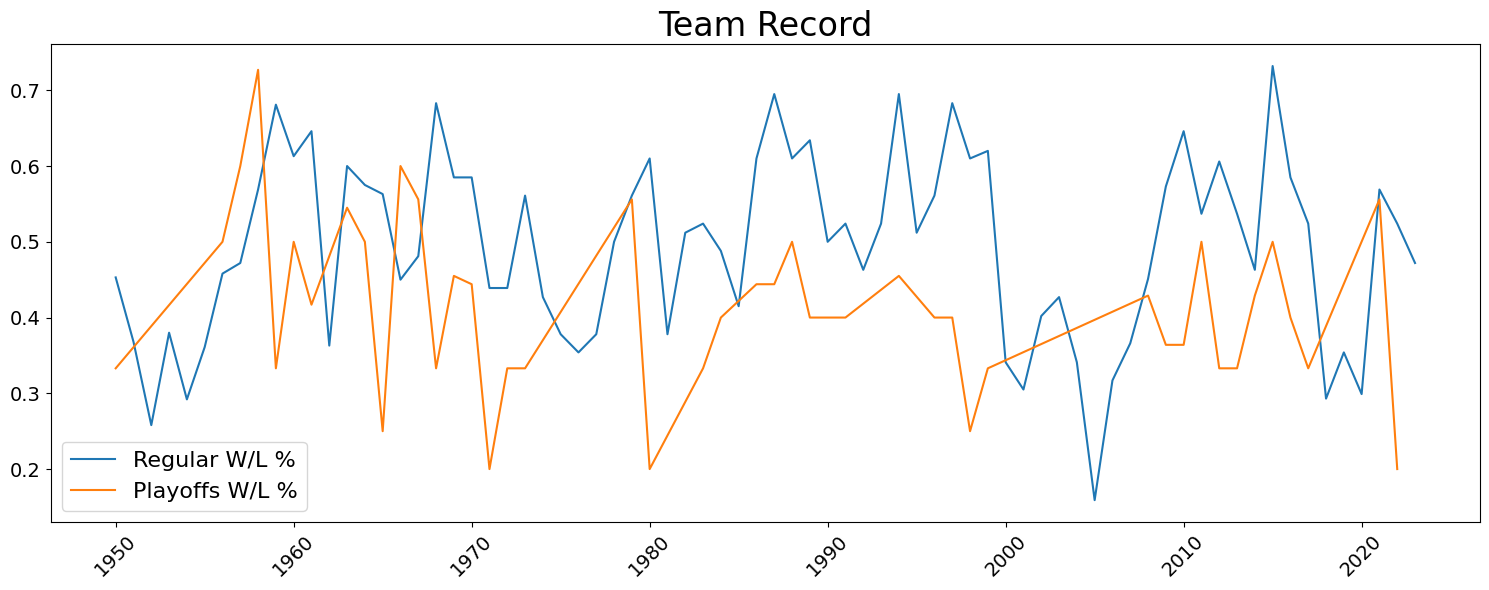

In [12]:
def team_stats_page(
    team_info: dict,
    team_stats: dict,
    team_record: dict,
) -> str:
    """
    Generates team stats page of the report.

    Returns: path to the PDF file (str)
    """

    if not os.path.exists("temp"):
        os.mkdir("temp")

    pdf = FPDF()

    pdf.add_font("FreeSans", "", "fonts/FreeSans.ttf")
    pdf.add_font("FreeSans", "B", "fonts/FreeSansBold.ttf")

    font_family = "FreeSans"
    title_font_size = 36
    text_font_size = 12
    text_color = hex_to_rgb(
        contrast([team_info["PrimaryColor"], team_info["SecondaryColor"]])
    )

    pdf.add_page()

    # Background
    primary = hex_to_rgb(team_info["PrimaryColor"])
    secondary = hex_to_rgb(team_info["SecondaryColor"])
    background = generate_gradient(
        round(pdf.w), round(pdf.h), [primary, secondary], seed=8
    )

    pdf.image(background, 0, 0, pdf.w, pdf.h)

    # Title
    pad_y = 8
    pdf.set_font(font_family, "B", title_font_size)
    pdf.set_text_color(*text_color)
    pdf.cell(w=pdf.epw, h=pad_y, txt="Team Stats", align="C")
    pdf.ln()

    # Table (Stat: Value)
    pdf.ln(10)
    title_table_h = pdf.eph * 0.65
    row_height = (title_table_h - pad_y - 10) // len(team_stats)
    col_widths = [pdf.epw // 2, pdf.epw // 2]

    pdf.set_font(font_family, "", text_font_size)
    for stat, val in team_stats.items():
        for i, text in enumerate([stat, val]):
            pdf.cell(w=col_widths[i], h=row_height, txt=str(text), align="C", border=1)
        pdf.ln(row_height)

    # Record TimeSeries Plot

    team_record.sort_values(by="Season", inplace=True)

    fig, ax = plt.subplots(figsize=(15, 6))
    regular = team_record[team_record["RegularW-L%"] != 0][["Season", "RegularW-L%"]]
    ax.plot(regular["Season"], regular["RegularW-L%"], label="Regular W/L %")
    playoffs = team_record[team_record["PlayoffsW-L%"] != 0][["Season", "PlayoffsW-L%"]]
    ax.plot(playoffs["Season"], playoffs["PlayoffsW-L%"], label="Playoffs W/L %")

    ax.set_title("Team Record", {"fontsize": 24})
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    ax.legend(fontsize=16)

    fig.tight_layout()

    # Save plot to BytesIO
    pdf.ln(10)
    y_margin = 10
    buf = BytesIO()
    fig.savefig(buf, format="png")
    buf.seek(0)
    pdf.image(
        buf,
        x=pdf.x,
        y=pdf.y + y_margin,
        w=pdf.epw,
        h=pdf.eph - title_table_h - 2 * y_margin,
    )
    buf.close()

    pdf_path = "temp/team_stats.pdf"

    pdf.output(pdf_path)

    return pdf_path


team_stats_pdf = team_stats_page(team_info, team_stats, team_record)


## Predictions

In [13]:
title, date, html_string, css_string = ETL.scrap_bettings(team_info["FullName"])
print(title)
print(date)


https://www.dratings.com/predictor/nba-basketball-predictions/upcoming/0
https://www.dratings.com/predictor/nba-basketball-predictions/upcoming/1
https://www.dratings.com/predictor/nba-basketball-predictions/upcoming/2
https://www.dratings.com/predictor/nba-basketball-predictions/upcoming/3
Game found in 3 days
Atlanta at Golden State
03:10 AM • Jan 3, 2023


In [14]:
def prediction(title, date, html_string, css_string):
    """
    Generates prediction page of the report.

    Returns: path to the PDF file (str)
    """

    if not os.path.exists("temp"):
        os.mkdir("temp")

    pdf = FPDF()

    pdf.add_font("FreeSans", "", "fonts/FreeSans.ttf")
    pdf.add_font("FreeSans", "B", "fonts/FreeSansBold.ttf")

    font_family = "FreeSans"
    title_font_size = 36
    text_font_size = 12
    text_color = hex_to_rgb(
        contrast([team_info["PrimaryColor"], team_info["SecondaryColor"]])
    )

    pdf.add_page()

    # Background
    primary = hex_to_rgb(team_info["PrimaryColor"])
    secondary = hex_to_rgb(team_info["SecondaryColor"])
    background = generate_gradient(
        round(pdf.w), round(pdf.h), [primary, secondary], seed=5
    )

    pdf.image(background, 0, 0, pdf.w, pdf.h)

    # Title
    pad_y = 20
    pdf.set_font(font_family, "B", title_font_size)
    pdf.set_text_color(*text_color)
    pdf.cell(w=pdf.epw, h=pad_y, txt=title, align="C")
    pdf.ln()

    # Date
    pdf.ln(3)
    pad_y = 10
    pdf.set_font(font_family, "B", 24)
    pdf.set_text_color(*text_color)
    pdf.cell(w=pdf.epw, h=pad_y, txt=date, align="C")
    pdf.ln()

    # Prediction
    hti = html2image.Html2Image(size=(1000, 250), output_path="temp")
    hti.screenshot(html_str=html_string, css_str=css_string, save_as="breakdown.png")
    pdf.ln(10)
    pdf.image(
        "temp/breakdown.png",
        x=pdf.x,
        y=pdf.y,
        w=pdf.epw,
        h=pdf.epw // 4 + 10,
    )

    pdf_path = "temp/prediction.pdf"

    pdf.output(pdf_path)

    return pdf_path


prediction_pdf = prediction(title, date, html_string, css_string)


Gradient generated


## Merging

In [15]:
# Merge PDFs
def merge_pdfs():
    """
    Merges PDFs into one.

    Returns: path to the merged PDF (str)
    """

    pdfs = [
        "front_page.pdf",
        "individual_info.pdf",
        "individual_stats.pdf",
        "team_stats.pdf",
        "prediction.pdf",
    ]

    merger = PdfMerger()

    for pdf in pdfs:
        merger.append("temp/" + pdf)

    if not os.path.exists("out"):
        os.mkdir("out")

    merger.write("out/report.pdf")
    merger.close()

    return "out/report.pdf"


merge_pdfs()


In [16]:
print("Done in {:.2f} seconds".format(time.time() - ini))

Done in 22.36 seconds
